In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "fmnist"
dims = (28, 28, 1)
num_classes = 10
labels_per_class = 256 # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline_augmented'
)
print(datestring)

fmnist_256____2020_08_25_23_02_42_403918_baseline_augmented


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_FMNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:
lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = dims
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(3, 3), strides=2, padding='valid'))


model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 28, 28, 128)       2689      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 28, 28, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 28, 28, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 28, 28, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 28, 28, 128)       2

### Augmentation

In [11]:
import tensorflow_addons as tfa

def norm(x):
    return( x - tf.reduce_min(x))#/(tf.reduce_max(x) - tf.reduce_min(x))

def augment(image, label):
    
    if tf.random.uniform((1,), minval=0, maxval = 2, dtype=tf.int32)[0] == 0:
        # stretch
        randint_hor = tf.random.uniform((2,), minval=0, maxval = 8, dtype=tf.int32)[0]
        randint_vert = tf.random.uniform((2,), minval=0, maxval = 8, dtype=tf.int32)[0]
        image = tf.image.resize(image, (dims[0]+randint_vert*2, dims[1]+randint_hor*2))
        #image = tf.image.crop_to_bounding_box(image, randint_vert,randint_hor,28,28)
        image = tf.image.resize_with_pad(
            image, dims[0], dims[1]
        )  

        image = tf.image.resize_with_crop_or_pad(
            image, dims[0] + 3, dims[1] + 3
        )  # crop 6 pixels
        image = tf.image.random_crop(image, size=dims)
    if tf.random.uniform((1,), minval=0, maxval = 2, dtype=tf.int32)[0] == 0:
        image = tfa.image.rotate(
            image,
            tf.squeeze(tf.random.uniform(shape=(1, 1), minval=-0.1, maxval=0.1)),
            interpolation="BILINEAR",
        )
    
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image, 0, 1)
    if tf.random.uniform((1,), minval=0, maxval = 2, dtype=tf.int32)[0] == 0:
        image = tf.image.random_brightness(image, max_delta=0.5)  # Random brightness
        image = tf.image.random_contrast(image, lower=0.5, upper=1.75)
        image = norm(image)
    
        image = tf.clip_by_value(image, 0, 1)
    
    image = tfa.image.random_cutout(
        tf.expand_dims(image, 0), (8, 8), constant_values=0.5
    )[0]

    image = tf.clip_by_value(image, 0, 1)
    return image, label

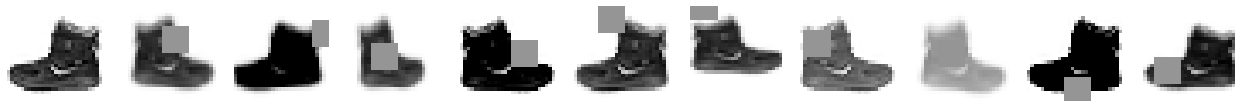

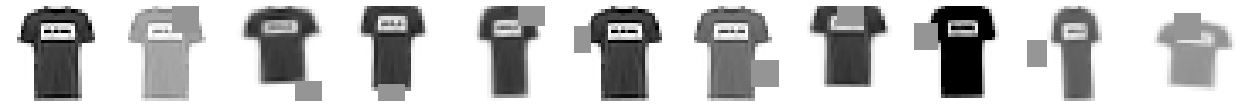

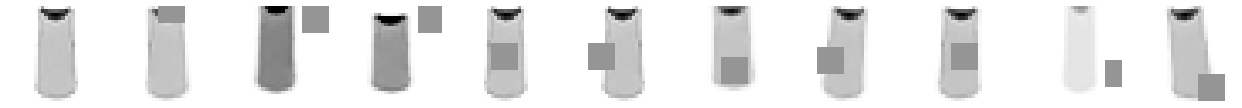

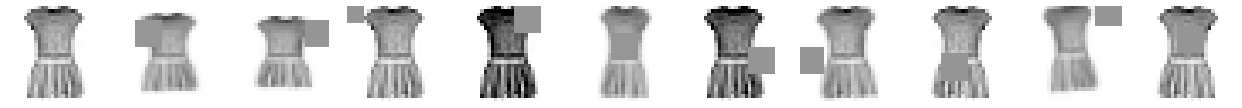

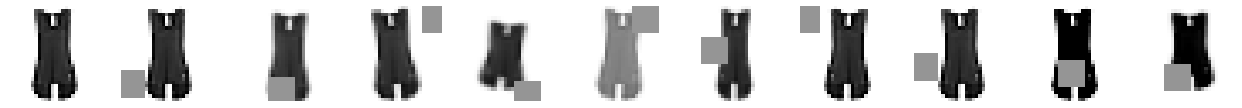

In [12]:
nex = 10
for i in range(5):
    fig, axs = plt.subplots(ncols=nex +1, figsize=((nex+1)*2, 2))
    axs[0].imshow(np.squeeze(X_train[i]), cmap = plt.cm.Greys)
    axs[0].axis('off')
    for ax in axs.flatten()[1:]:
        aug_img = np.squeeze(augment(X_train[i], Y_train[i])[0])
        ax.matshow(aug_img, cmap = plt.cm.Greys, vmin=0, vmax=1)
        ax.axis('off')

### train

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=100, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True
)

In [14]:
image = X_train[i]
print(image.shape)
# stretch
# stretch
randint_hor = tf.random.uniform((2,), minval=0, maxval = 8, dtype=tf.int32)[0]
randint_vert = tf.random.uniform((2,), minval=0, maxval = 8, dtype=tf.int32)[0]
image = tf.image.resize(image, (dims[0]+randint_vert*2, dims[1]+randint_hor*2))
image = tf.image.crop_to_bounding_box(image, randint_vert,randint_hor,28,28)
print(image.shape)

(28, 28, 1)
(28, 28, 1)


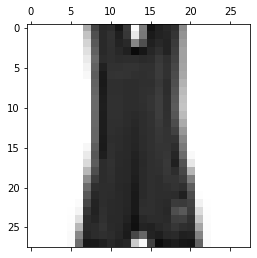

In [15]:
plt.matshow(np.squeeze(image), cmap = plt.cm.Greys, vmin=0, vmax=1)

In [16]:
import tensorflow_addons as tfa

In [17]:
opt = tf.keras.optimizers.Adam(1e-4)
opt = tfa.optimizers.MovingAverage(opt)
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)
model.compile(opt, loss = loss, metrics=['accuracy'])

In [18]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [19]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [20]:
from livelossplot import PlotLossesKerasTF
# plot losses callback
plotlosses = PlotLossesKerasTF()

In [21]:
train_ds = (
     tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot))
    .repeat()
    .shuffle(len(X_labeled))
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.experimental.AUTOTUNE)
) 

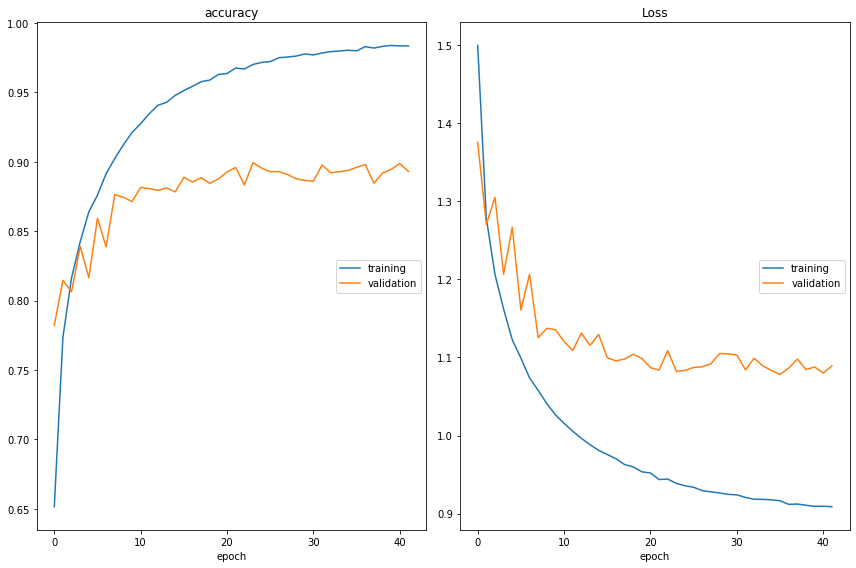

accuracy
	training         	 (min:    0.651, max:    0.984, cur:    0.984)
	validation       	 (min:    0.782, max:    0.899, cur:    0.893)
Loss
	training         	 (min:    0.909, max:    1.499, cur:    0.909)
	validation       	 (min:    1.078, max:    1.375, cur:    1.089)
390/390 [==============================] - 257s 658ms/step - loss: 0.9089 - accuracy: 0.9836 - val_loss: 1.0892 - val_accuracy: 0.8931
Epoch 43/500
386/390 [============================>.] - ETA: 2s - loss: 0.9063 - accuracy: 0.9854

In [ ]:
steps_per_epoch = int(len(X_train)/ batch_size)

history = model.fit(
    train_ds,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping, plotlosses],
    steps_per_epoch = steps_per_epoch,
)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

In [ ]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [ ]:
predictions = model.predict(X_valid)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [ ]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

### save results

In [ ]:
# save score, valid embedding, weights, results

In [ ]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [ ]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [ ]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [ ]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [ ]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

In [ ]:
classifier.save_weights((save_folder / "classifier").as_posix())

#### save score

In [ ]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

In [ ]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [ ]:
z = encoder.predict(X_train)

In [ ]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [ ]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [ ]:
import pickle

In [ ]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)